In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator
from matplotlib.patches import Patch
import xarray as xr 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime 
import pytz
import csv
import seaborn as sns
from scipy.stats import kde
from scipy.stats import gaussian_kde
import plotly.express as px
from haversine import haversine
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
import netCDF4
import xskillscore as xs
import geopandas as gpd
from scipy import stats
import rioxarray 
from mpl_toolkits.axes_grid1 import make_axes_locatable
proj = ccrs.PlateCarree()

#Plotting with h3 uber 
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import RobustScaler
import h3

#Masking array
from rechunker import rechunk
from rasterio import features
from affine import Affine
from shapely.geometry import Point
from shapely.geometry import Polygon

#External functions 
import fct.fct_link_storm_claim as fct_link_storm_claim
import fct.preprocess_sinclim as preprocess_sinclim
from fct.paths import *

path_save_fig = PATH_FIGURE#+"storm_catalogue/summary/"

In [3]:
period = "1979-2024WIN"
df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_1979-2024WIN_info_SSI-wgust-q98_r1300.csv", encoding="utf-8")
df_info_storm_SSI = df_info_storm_SSI.rename(columns={'SSI_FRA_wgust_q98' : "SSI_FRA"})
df_info_storm = pd.merge(df_info_storm, df_info_storm_SSI[['storm_id', 'SSI_FRA']], on='storm_id')

########## IMPACT DATA 
window        = 'd-3_d+3'
min_claim     = 50
method        = 'wgust'
r             = 1300

sinclim = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, window, min_claim, method, period, r)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]
print(f"{df_info_storm_impact.storm_id.nunique()} storms with impact")

#Add storm_landing date and SSI
sinclim = pd.merge(sinclim, df_info_storm_impact[['storm_id', 'storm_landing_date', 'SSI_FRA']], on='storm_id', how='left')

#Load clusters 
windi = 96
r     = 700

df_storm_cluster_test                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r"+str(r)+"_"+period+".csv", encoding='utf-8')
df_info_mult_cluster_test                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r"+str(r)+"_"+period+"_info.csv", encoding='utf-8')
df_info_mult_cluster_test['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster_test['storm_landing_date'])

df_info_mult_cluster_test = pd.merge(df_info_mult_cluster_test, df_info_storm[['storm_id', 'SSI_FRA']], on="storm_id", how="left")

4439 number of storms
344 storms with impact


In [4]:
############ Open the needed data and perform the association 
sinclim_raw = pq.read_table(PATH_GENERALI+'sinclim_v2.1_anom.parquet')
sinclim_raw      =  sinclim_raw.to_pandas(date_as_object = True, safe = False)
sinclim_raw_sort = sinclim_raw.sort_values('dat_sin')

sinclim_raw_storm = fct_link_storm_claim.claims_preprocess(sinclim_raw_sort, "tempete")
print(f"{len(sinclim_raw_storm)} claims in raw dataset")
print(f"{len(sinclim)} claims after association")

210435 claims in raw dataset
201591 claims after association


In [5]:
#Quality of the geo-coding 
sinclim.groupby('lib_geo')['lib_geo'].value_counts()/len(sinclim)#.unstack(fill_value=0)

lib_geo    lib_geo  
bon        bon          0.551334
excellent  excellent    0.126474
mauvais    mauvais      0.096180
moyen      moyen        0.226012
Name: lib_geo, dtype: float64

In [6]:
sinclim_raw_storm.groupby('lib_eta')['lib_eta'].value_counts()/len(sinclim_raw_storm)

lib_eta  lib_eta
clos     clos       0.967068
ouvert   ouvert     0.032932
Name: lib_eta, dtype: float64

In [7]:
### Only raw claim dates
sinclim_storm = sinclim.groupby("storm_id").agg(num_chg_brut_tot = ('num_chg_brut_cst', 'sum'),
                                                nb_claims        = ('cod_sin', 'count'), 
                                                storm_landing_date = ('storm_landing_date', 'first'), 
                                                SSI_FRA = ("SSI_FRA", "first")
                                               ).reset_index()

#Add the winter season
sinclim_storm['season'] = sinclim_storm['storm_landing_date'].apply(
    lambda x: x.year if x.month >= 9 else (x.year - 1 if x.month <= 3 else None)
)
sinclim_storm['season'] = sinclim_storm['season'].fillna(sinclim_storm['storm_landing_date'].dt.year)

# Time series most intense storms 

In [8]:
# For d-3 d+3
storm_names = ['Anatol', "Lothar", "Martin", "Jeannett", "Dagmar", "Renate", None,  "Kyrill", None, "Klaus", "Quinten", "Xynthia", "Joachim", None, "Dirk", None, "Egon", "Leiv", None, "Zeus", "Carmen", "Eleanor", "Adrian", "Eberhard", "Amelie", None, "Fabien", None, None, None, "Ciara", "Ines", "Karine", "Aurore", "Eunice", None, "Gérard", "Larisa", "Ciaran", "Domingos", "Frederico"]

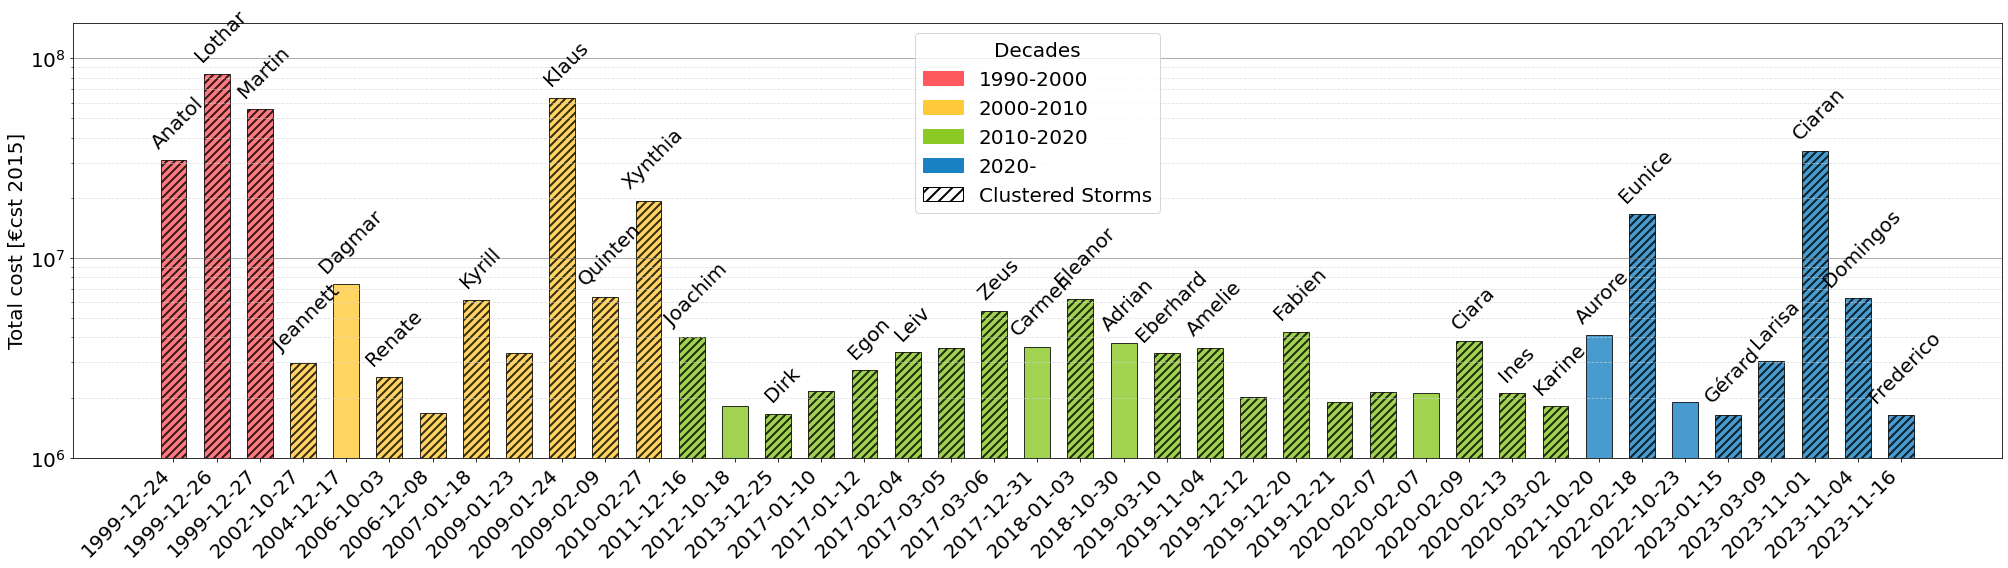

In [9]:
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
fontsize=20

# Define colors for different decades
colors = {
    '1990-2000': '#FF595E',  # Red-orange
    '2000-2010': '#FFCA3A',  # Yellow
    '2010-2020': '#8AC926',  # Green
    '2020-': '#1982C4'       # Blue
}

# Filter on the most impactful storms
nb_top = 40
nb_claims_lim = sinclim_storm.sort_values(by='num_chg_brut_tot', ascending=False).iloc[40].num_chg_brut_tot
sinclim_storm_top = sinclim_storm.loc[sinclim_storm.num_chg_brut_tot >= nb_claims_lim]

# Determine the decade for each storm
decades = []
for year in sinclim_storm_top.season:
#     year = date.year
    if 1990 <= year < 2000:
        decades.append('1990-2000')
    elif 2000 <= year < 2010:
        decades.append('2000-2010')
    elif 2010 <= year < 2020:
        decades.append('2010-2020')
    else:
        decades.append('2020-')

# Map each storm to its color
bar_colors = [colors[dec] for dec in decades]
cluster_storms = set(df_info_mult_cluster_test.storm_id)

# Plot
fig = plt.figure(figsize=(28, 8))
bars = plt.bar(sinclim_storm_top.storm_id, sinclim_storm_top.num_chg_brut_tot, 
               color=bar_colors, alpha=0.8, edgecolor='black', width=0.6)

# Apply hatching to storms in a cluster
for bar, storm_id in zip(bars, sinclim_storm_top.storm_id):
    if storm_id in cluster_storms:
        bar.set_hatch('///')  # Dashed pattern

# Set up y-axis (symlog scale)
plt.yscale('symlog', linthresh=10**6)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.7)

# Labels and title
plt.ylabel('Total cost [€cst 2015]', fontsize=fontsize)
plt.ylim((10**6, 1.5*10**8))

# Customize x-axis labels
date_ticks = [date.strftime('%Y-%m-%d') for date in sinclim_storm_top.storm_landing_date]
plt.xticks(ticks=sinclim_storm_top.storm_id, labels=date_ticks, rotation=45, ha='right', fontsize=fontsize)
plt.yticks(fontsize=20)

# Add storm names above each bar
for bar, storm_name in zip(bars, storm_names):  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 +0.1, height * 1.1, storm_name, 
             ha='center', va='bottom', fontsize=fontsize, rotation=45)

# Add legend
legend_patches = [Patch(color=color, label=dec) for dec, color in colors.items()]
legend_patches.append(Patch(facecolor='white', edgecolor='black', hatch='//', label="Clustered Storms"))

plt.legend(handles=legend_patches, title="Decades", title_fontsize=fontsize, fontsize=fontsize, loc='upper center')

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(path_save_fig+'top'+str(nb_top)+"-cost_storm_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300_with-clust.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+'top'+str(nb_top)+"-cost_storm_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300_with-clust.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+'top'+str(nb_top)+"-cost_storm_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300_with-clust.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)

In [10]:
# For d-3 d+3
storm_names_nb_claims = ['Anatol', "Lothar", "Martin", "Jeannett", "Dagmar", "Renate", None,  "Kyrill", None, "Klaus", "Quinten", "Xynthia", "Gunter", "Joachim", None, None, "Dirk", "Henri", "Nannette", None, "Egon", "Leiv", None, "Zeus", "Ana", "Carmen", "Eleanor", "Eberhard", "Amelie", None, "Fabien", None, None, None, "Ciara", "Ines", "Karine", "Aurore", "Eunice", "Larisa", "Ciaran", "Domingos"]

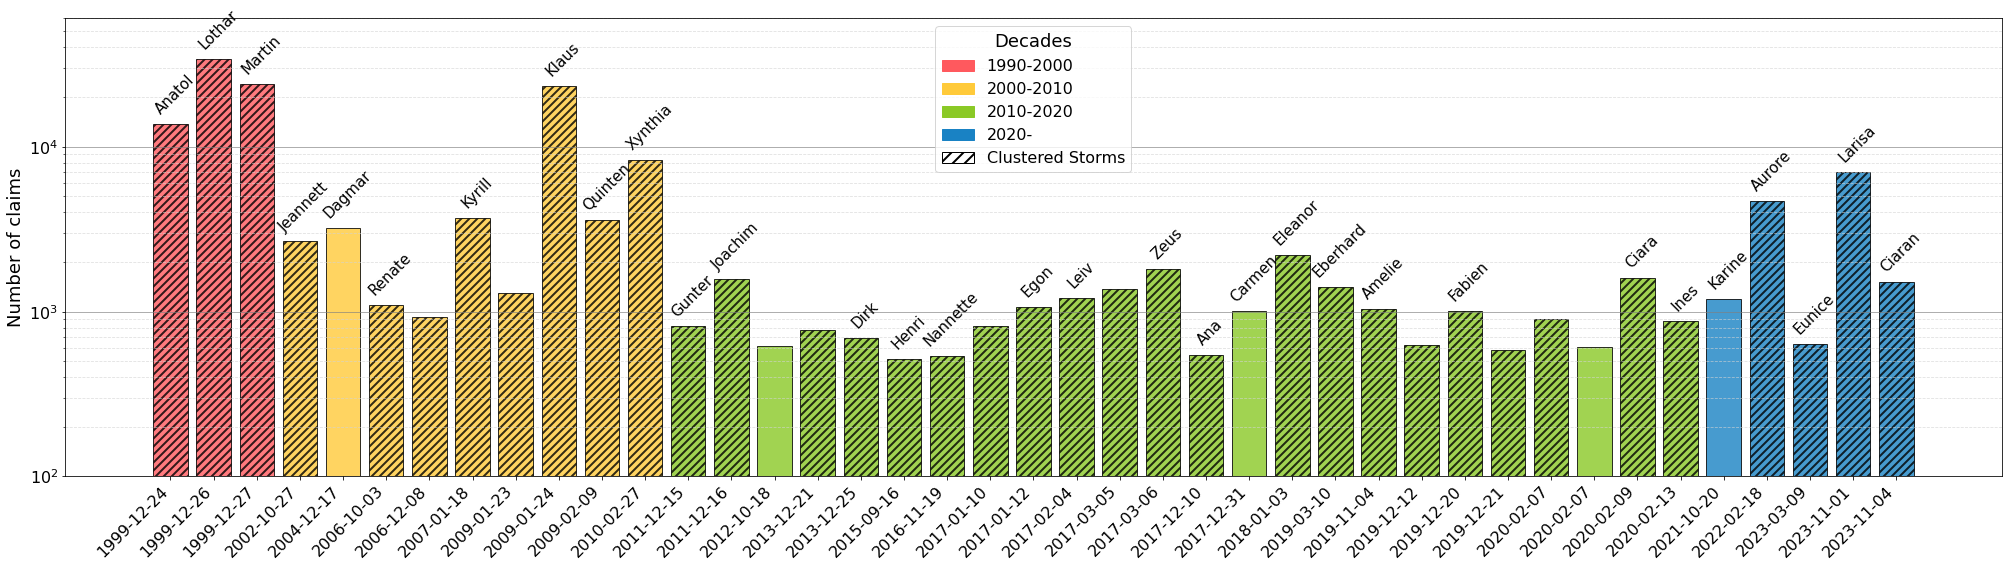

In [11]:
# Same plot as above but with the total number of claims per event 
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth

# Define colors for different decades
colors = {
    '1990-2000': '#FF595E',  # Red-orange
    '2000-2010': '#FFCA3A',  # Yellow
    '2010-2020': '#8AC926',  # Green
    '2020-': '#1982C4'       # Blue
}

# Filter on the most impactful storms
nb_top = 40
nb_claims_lim = sinclim_storm.sort_values(by='nb_claims', ascending=False).iloc[40].nb_claims
sinclim_storm_top = sinclim_storm.loc[sinclim_storm.nb_claims >= nb_claims_lim]

# Determine the decade for each storm
decades = []
for year in sinclim_storm_top.season:
#     year = date.year
    if 1990 <= year < 2000:
        decades.append('1990-2000')
    elif 2000 <= year < 2010:
        decades.append('2000-2010')
    elif 2010 <= year < 2020:
        decades.append('2010-2020')
    else:
        decades.append('2020-')

# Map each storm to its color
bar_colors = [colors[dec] for dec in decades]
cluster_storms = set(df_info_mult_cluster_test.storm_id)

# Plot
fig = plt.figure(figsize=(28, 8))
bars = plt.bar(sinclim_storm_top.storm_id, sinclim_storm_top.nb_claims, 
               color=bar_colors, alpha=0.8, edgecolor='black')

# Apply hatching to storms in a cluster
for bar, storm_id in zip(bars, sinclim_storm_top.storm_id):
    if storm_id in cluster_storms:
        bar.set_hatch('///')  # Dashed pattern

# Set up y-axis (symlog scale)
plt.yscale('symlog', linthresh=10**2)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
plt.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.8)
plt.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.7)

# Labels and title
plt.ylabel('Number of claims', fontsize=18)
plt.ylim((10**2, 6*10**4))

# Customize x-axis labels
date_ticks = [date.strftime('%Y-%m-%d') for date in sinclim_storm_top.storm_landing_date]
plt.xticks(ticks=sinclim_storm_top.storm_id, labels=date_ticks, rotation=45, ha='right', fontsize=16)
# plt.yticks(ticks=[])
plt.yticks(fontsize=16)

# Add storm names above each bar
for bar, storm_name in zip(bars, storm_names_nb_claims):  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 +0.1, height * 1.1, storm_name, 
             ha='center', va='bottom', fontsize=15, rotation=45)

# Add legend
legend_patches = [Patch(color=color, label=dec) for dec, color in colors.items()]
legend_patches.append(Patch(facecolor='white', edgecolor='black', hatch='//', label="Clustered Storms"))

plt.legend(handles=legend_patches, title="Decades", title_fontsize=18, fontsize=16, loc='upper center')

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(path_save_fig+'top'+str(nb_top)+"-nb-claims_storm_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300_with-clust.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+'top'+str(nb_top)+"-nb-claims_storm_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300_with-clust.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+'top'+str(nb_top)+"-nb-claims_storm_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300_with-clust.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)

# Yearly variability

In [12]:
sinclim_storm = sinclim_storm.merge(df_info_mult_cluster_test[["storm_id", "clust_id"]], how='left', on="storm_id")

In [13]:
sinclim_storm['season'] = sinclim_storm['storm_landing_date'].apply(
    lambda x: x.year if x.month >= 9 else (x.year - 1 if x.month <= 3 else None)
)
sinclim_storm['season'] = sinclim_storm['season'].fillna(sinclim_storm['storm_landing_date'].dt.year)

In [14]:
sinclim_storm_grp_winter = sinclim_storm.groupby("season").agg(num_chg_brut_tot = ('num_chg_brut_tot', 'sum'),
                                                               nb_claims        = ('nb_claims', 'sum'),
                                                               nb_storm         = ('storm_id', 'nunique'), 
                                                               nb_clust         = ('clust_id', 'nunique'), 
                                                               nb_storm_clust   = ('clust_id', 'count')).reset_index()

In [15]:
#For cluster 
sinclim_clust = sinclim_storm.dropna(subset="clust_id")
sinclim_clust_grp_winter = sinclim_clust.groupby("season").agg(num_chg_brut_tot = ('num_chg_brut_tot', 'sum'),
                                                               nb_claims        = ('nb_claims', 'sum'),
                                                               nb_storm         = ('storm_id', 'nunique'), 
                                                               nb_clust         = ('clust_id', 'nunique')).reset_index()

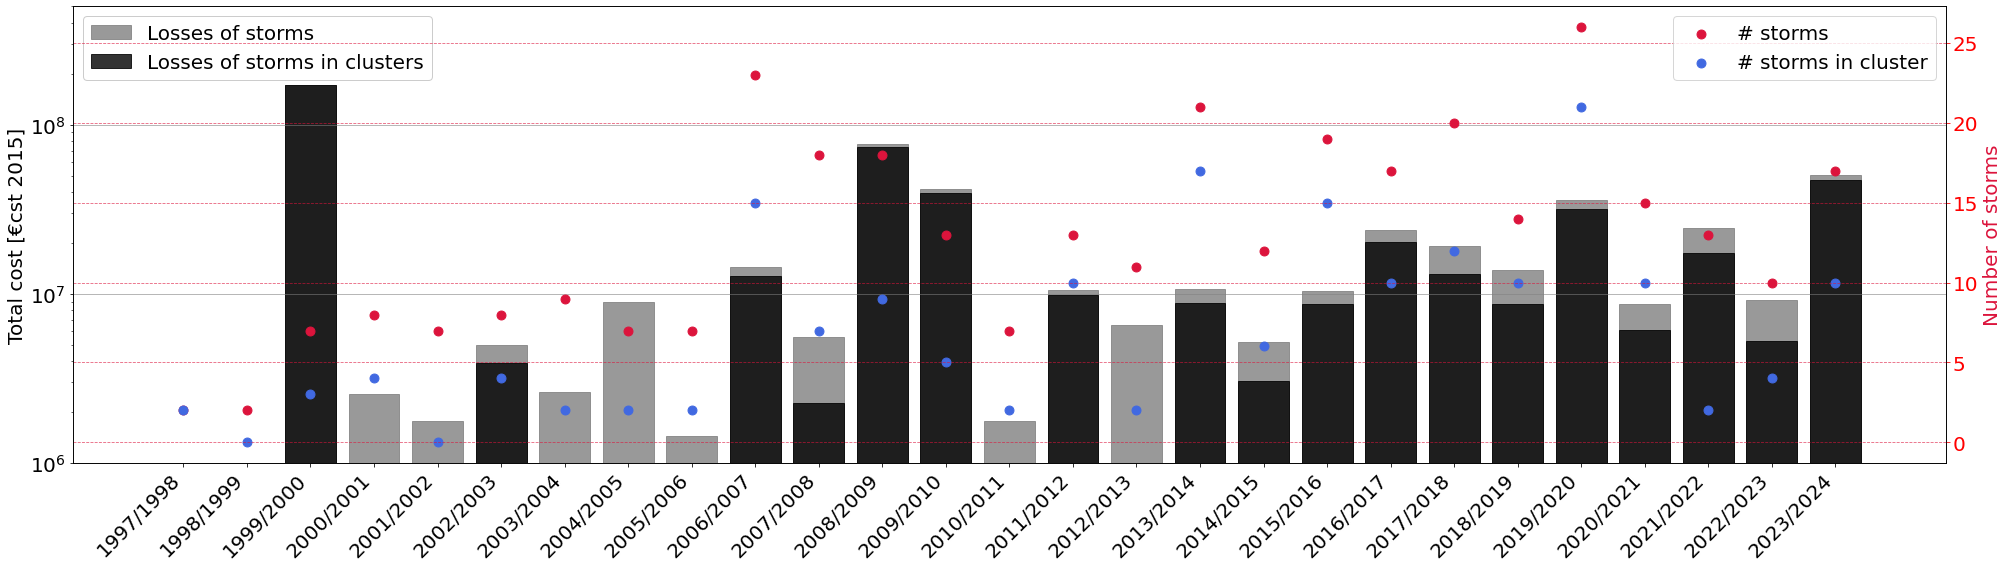

In [16]:
# Plot
fontsize=20
fig, ax1 = plt.subplots(figsize=(28, 8))
bars = ax1.bar(sinclim_storm_grp_winter.season, sinclim_storm_grp_winter.num_chg_brut_tot, 
               alpha=0.8, edgecolor='gray', color='gray', label="Losses of storms")
ax1.bar(sinclim_clust_grp_winter.season, sinclim_clust_grp_winter.num_chg_brut_tot, 
               alpha=0.8, edgecolor='black', color='black', label="Losses of storms in clusters")
plt.legend(fontsize=fontsize, loc='upper left', facecolor='white', framealpha=1)

# Set up y-axis (symlog scale)
ax1.set_yscale('symlog', linthresh=10**6)
ax1.yaxis.set_major_locator(LogLocator(base=10.0))
ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
ax1.grid(which='major', axis='y', linestyle='-', color='gray', alpha=0.7)
# ax1.grid(which='minor', axis='y', linestyle='--', color='lightgray', alpha=0.5)

# Labels and title
ax1.set_ylabel('Total cost [€cst 2015]', fontsize=fontsize)
ax1.set_ylim((10**6, 5*10**8))
ax1.tick_params(axis='y', which='major', labelsize=fontsize)

# Number of storm count
ax2 = ax1.twinx()
ax2.scatter(sinclim_storm_grp_winter.season, sinclim_storm_grp_winter.nb_storm, 
            s=80, label='# storms', color="crimson")
ax2.scatter(sinclim_storm_grp_winter.season, sinclim_storm_grp_winter.nb_storm_clust, 
            s=80, label='# storms in cluster', color="royalblue")
ax2.tick_params(axis='y', which='major', labelsize=fontsize, colors="red")
ax2.grid(which='major', axis='y', linestyle='--', color='crimson', alpha=0.7)
ax2.set_ylabel('Number of storms', fontsize=fontsize, color='crimson')

# Customize x-axis labels
# date_ticks = [date.strftime('%Y-%m-%d') for date in sinclim_storm_top.storm_landing_date]
# ax1.set_xticks(ticks=sinclim_storm_grp_winter.season, labels=sinclim_storm_grp_winter.season, rotation=45, ha='right', fontsize=16)
season_labels = [f"{year}/{str(year + 1)}" for year in sinclim_storm_grp_winter.season]
ax1.set_xticks(ticks=sinclim_storm_grp_winter.season)
ax1.set_xticklabels(labels=season_labels, rotation=45, ha='right', fontsize=fontsize)

plt.tight_layout()
plt.legend(fontsize=fontsize)
plt.show()
# Save figure
fig.savefig(path_save_fig+"summary-per-season_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"summary-per-season_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"summary-per-season_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)

# Global metrics per storm and per event 

In [17]:
sinclim_storm["mean_cost"] = sinclim_storm["num_chg_brut_tot"]/sinclim_storm["nb_claims"]

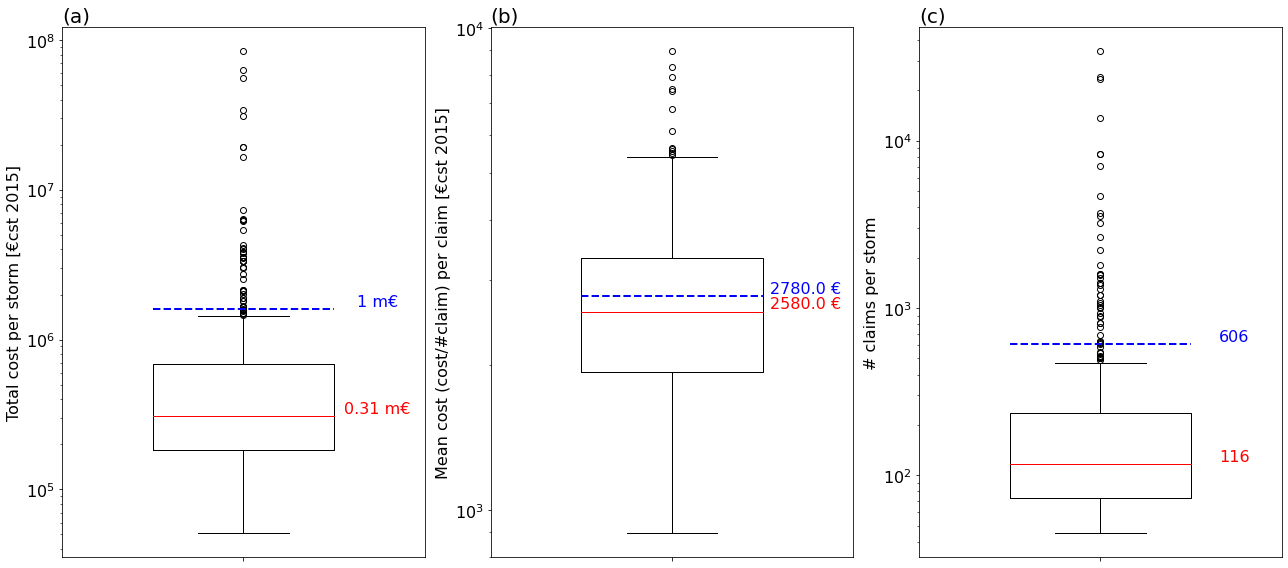

In [18]:
fig, ax = plt.subplots(1, 3, figsize=[18, 8])
boxplot_width = 0.5

# Cost per storm (with log scale)
cost_per_storm = [(sinclim_storm['num_chg_brut_tot']).values]
bp0 = ax[0].boxplot(cost_per_storm, positions=[0], widths=boxplot_width, medianprops={'color': 'red'})
ax[0].set_xticklabels([], fontsize=14)
ax[0].set_yscale('log')
ax[0].set_ylabel('Total cost per storm [€cst 2015]', fontsize=16)
ax[0].set_title("(a)", loc='left', fontsize=20)

# Add median value
for i, data in enumerate(cost_per_storm):
    median_value = np.round(np.median(data)/1e6, 2)
    ax[0].text(i+0.37, median_value*1e6, f'{median_value} m€', ha='center', va='bottom', fontsize=16, color='red')

# Add mean line and value
for i, data in enumerate(cost_per_storm):
    mean_value = np.mean(data)/1e6
    ax[0].plot([i - boxplot_width / 2, i + boxplot_width / 2], [mean_value*1e6, mean_value*1e6], color='blue', linestyle='dashed', linewidth=2)
    ax[0].text(i+0.37, mean_value*1e6, f'{int(mean_value)} m€', ha='center', va='bottom', fontsize=16, color='blue')

# Mean cost per claim (log scale)
mean_cost_per_claim = [sinclim_storm['mean_cost'].values]
bp1 = ax[1].boxplot(mean_cost_per_claim, positions=[0], widths=boxplot_width, medianprops={'color': 'red'})
ax[1].set_xticklabels([], fontsize=14)
ax[1].set_yscale('log')
ax[1].set_ylabel('Mean cost (cost/#claim) per claim [€cst 2015]', fontsize=16)
ax[1].set_title("(b)", loc='left', fontsize=20)

# Add median value 
for i, data in enumerate(mean_cost_per_claim):
    median_value = np.round(np.median(data)/1e3, 2)
    ax[1].text(i+0.37, median_value*1e3, f'{median_value*1e3} €', ha='center', va='bottom', fontsize=16, color='red')

# Add mean line and value
for i, data in enumerate(mean_cost_per_claim):
    mean_value = np.round(np.mean(data)/1e3, 2)
    ax[1].plot([i - boxplot_width / 2, i + boxplot_width / 2], [mean_value*1e3, mean_value*1e3], color='blue', linestyle='dashed', linewidth=2)
    ax[1].text(i + 0.37, mean_value*1e3, f'{mean_value*1e3} €', ha='center', va='bottom', fontsize=16, color='blue')

# Claims per storm (with log scale)
claims_per_storm = [sinclim_storm['nb_claims'].values]
bp2 = ax[2].boxplot(claims_per_storm, positions=[0], widths=boxplot_width, medianprops={'color': 'red'})
ax[2].set_xticklabels([], fontsize=14)
ax[2].set_yscale('log')
ax[2].set_ylabel('# claims per storm', fontsize=16)
ax[2].set_title("(c)", loc='left', fontsize=20)

# Add median value 
for i, data in enumerate(claims_per_storm):
    median_value = int(np.median(data))
    ax[2].text(i+0.37, median_value, f'{median_value}', ha='center', va='bottom', fontsize=16, color='red')

# Add mean line and value
for i, data in enumerate(claims_per_storm):
    mean_value = np.mean(data)
    ax[2].plot([i - boxplot_width / 2, i + boxplot_width / 2], [mean_value, mean_value], color='blue', linestyle='dashed', linewidth=2)
    ax[2].text(i + 0.37, mean_value, f'{int(mean_value)}', ha='center', va='bottom', fontsize=16, color='blue')

for axi in ax: 
    axi.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

#SAVE FIG
fig.savefig(path_save_fig+"summary-cost_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"summary-cost_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"summary-cost_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)

In [19]:
# Evolution of the mean cost per winter season 
season_order = sorted(sinclim_storm['season'].unique())
sinclim_storm['season'] = pd.Categorical(sinclim_storm['season'], categories=season_order, ordered=True)

# Group data by season
grouped = [sinclim_storm[sinclim_storm['season'] == season]['mean_cost'] for season in season_order]
counts = [len(group) for group in grouped]
means = [group.mean() for group in grouped]

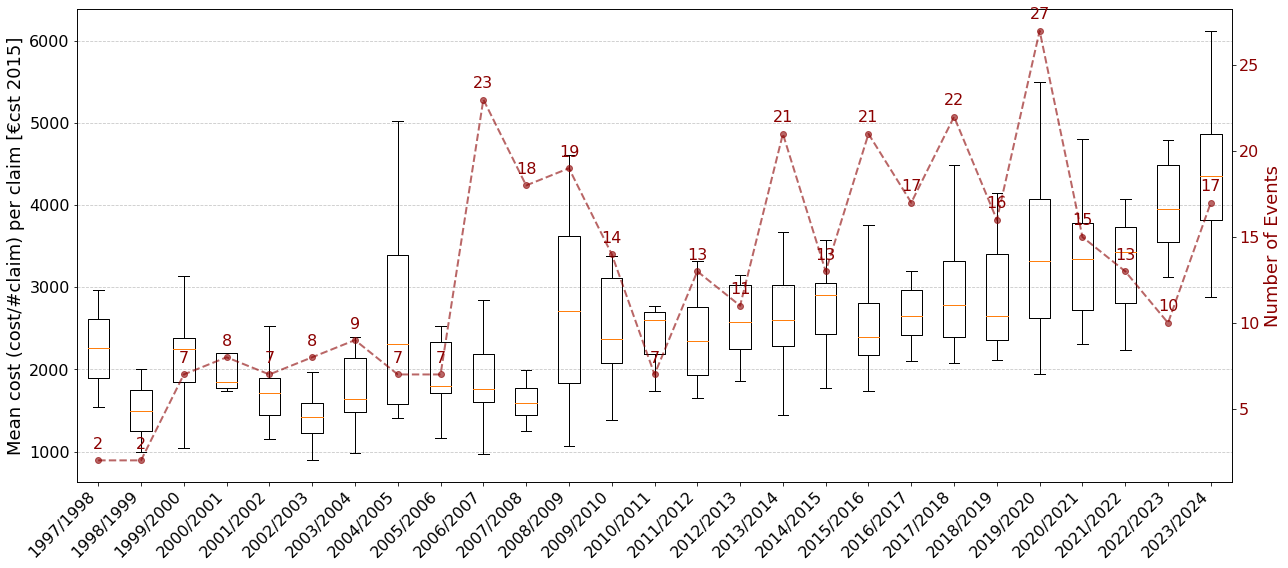

In [20]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(18, 8))

# Boxplot on primary y-axis (left)
box = ax1.boxplot(grouped, showfliers=False)
# ax1.set_xlabel('Season', fontsize=18)
ax1.set_ylabel('Mean cost (cost/#claim) per claim [€cst 2015]', fontsize=18)
# ax1.set_title('Mean Cost Distribution and Event Count per Season', fontsize=20)
ax1.tick_params(axis='x', rotation=45, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Apply new season labels
season_labels = [f"{year}/{str(year + 1)}" for year in season_order]
ax1.set_xticks(range(1, len(season_order) + 1))
ax1.set_xticklabels(season_labels, ha='right')

# Add red mean line
# ax1.plot(range(1, len(season_order) + 1), means, color='red', marker='s', linestyle='-', linewidth=2, label='Mean')

# Secondary y-axis for event counts
ax2 = ax1.twinx()
ax2.plot(range(1, len(season_order) + 1), counts, color='darkred', marker='o', linestyle='--', alpha=0.6, linewidth=2, label='Event Count')
ax2.set_ylabel('Number of Events', color='darkred', fontsize=18)
ax2.tick_params(axis='y', labelcolor='darkred', labelsize=16)

# Add count labels
for i, count in enumerate(counts):
    ax2.text(i + 1, count + max(counts) * 0.025, str(count), color='darkred', ha='center', fontsize=16)

plt.tight_layout()
plt.show()
#SAVE FIG
fig.savefig(path_save_fig+"timeserie_mean-cost_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"timeserie_mean-cost_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"timeserie_mean-cost_"+window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)